In [1]:
pwd

'/home/mohit19014/Hostility Detection/Final Experiments/HindiBERT/Final Test Pipeline'

In [2]:
ls

 Data/
'defamation,fake Defamation.tex'
'defamation,fake Fake.tex'
'defamation,fake Hate.tex'
'defamation,fake Offensive.tex'
'defamation,hate,offensive Defamation.tex'
'defamation,hate,offensive Fake.tex'
'defamation,hate,offensive Hate.tex'
'defamation,hate,offensive Offensive.tex'
 emoji2vec/
'fake,offensive Defamation.tex'
'fake,offensive Fake.tex'
'fake,offensive Hate.tex'
'fake,offensive Offensive.tex'
'Final Evaluation.ipynb'
'Final Pipeline (1).ipynb'
'Final Pipeline - Do not Delete.ipynb'
'Final Pipeline.ipynb'
'hate Defamation.tex'
'hate Fake.tex'
'hate Hate.tex'
'hate,offensive Defamation.tex'
'hate,offensive Fake.tex'
'hate,offensive Hate.tex'
'hate,offensive Offensive.tex'
'hate Offensive.tex'
 Model/


In [3]:
!nvidia-smi

Thu Jun 17 20:40:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:5E:00.0 Off |                    0 |
| N/A   39C    P0    41W / 250W |   1425MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Installing Required Libraries

In [4]:
# !git clone https://github.com/uclnlp/emoji2vec  #for emoji2vec file

In [5]:
# pip install fasttext

In [6]:
# pip install gensim

In [7]:
# pip install transformers -q

In [8]:
# pip install sentencepiece -q

<h4> Importing Libraries

In [9]:
### General
import re
import copy
import string
import pickle
import numpy as np
import pandas as pd
import fasttext
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

### Sklearn
import joblib
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

### Transformers
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

### For Emojis and Hashtags
import emoji
from inltk.inltk import tokenize
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from ekphrasis.classes.segmenter import Segmenter


import gensim.models as gsm
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors


### ASL
# from ASL.src.loss_functions.losses import AsymmetricLoss

In [10]:
MAX_LENGTH = 128

tokenizer   = AutoTokenizer.from_pretrained('monsoon-nlp/hindi-bert')
bert_model  = AutoModel.from_pretrained('monsoon-nlp/hindi-bert', output_hidden_states = True, output_attentions = True)


In [11]:
ft_model = fasttext.load_model('Data/IndicFT/indicnlp.ft.hi.300.bin')

In [12]:
seg_tw = Segmenter(corpus = "twitter")

Reading twitter - 1grams ...
Reading twitter - 2grams ...


#### Configuration Class


In [13]:
class Config1:
    def __init__(self):
        super(Config1, self).__init__()

        self.SEED       = 42
#         self.MODEL_PATH = 'Models/IndicBert'#'ai4bharat/indic-bert'
#         self.MODEL_PATH = 'Models/IndicBert'
#         self.MODEL_PATH = 'monsoon-nlp/hindi-bert'
        self.MODEL_PATH = 'Data/Pretrained/HindiBERT/Checkpoint 2500/'



        # data
        self.PERCENTAGE_DATA  = 10
        self.TOKENIZER        = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH       = 128
        self.BATCH_SIZE       = 16
        self.VALIDATION_SPLIT = 0.10
        self.PREPROCESS_INPUT = False

        # Coarse-grained or Fine-Grained
        self.NUM_LABELS           = 4                                        ### 1:CG   2:Combine    4:FG
        self.COARSE_GRAINED       = True if self.NUM_LABELS ==1 else False 
        self.COARSE_GRAINED_CLASS = 'Hostile'                                ### 'Fake' 'Defamation' 'Hate' or 'Offensive' 
        
        # Combining Hostile Dimensions
        self.COMBINE_HATE_OFFENSIVE  = False     #True if self.NUM_LABELS ==2 else False
        self.COMBINE_DEFAMATION_FAKE = False     #if self.NUM_LABELS ==2 else False


        ###Features to include
        self.SUPERVISED_LEXICON_ATTENTION = True
        self.HOSTILITY_LEXICON            = True
        self.LEXICON_AVERAGE              = False
        self.EMOJI_INFO                   = True
        self.EMBED_EMOJI                  = False    ### Doesnot do preprocessing, just adds emoji text into the post
        self.HASHTAG_INFO                 = True
        self.EMOJI_FLAG                   = " with Emoji"       ### "" or " without Emoji" or " with Emoji" --> space at beginning
        self.TOKENIZER_FLAG               = "Sentence Piece"
        self.PREPROCESSING_FLAG           = "Raw Text"
        
        ### Lexicon Parameters
        self.PAD_LENGTH = 128   ### Makes Sequence Length, Lexicon Vector, and gold attention vector 
        

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.NUMBER_OF_BERT_LAYERS = 1
        self.FULL_FINETUNING = True
        self.LR = 0.001
        self.OPTIMIZER = 'AdamW'
        self.OUTPUT_HIDDEN_STATE=True
        self.OUTPUT_ATTENTIONS = True
        self.EPOCHS = 50

        
        ### Loss Hyperparameters
        self.DEFAMATION_LOSS_LAMBDA = 1.0
        self.FAKE_LOSS_LAMBDA       = 1.0
        self.HATE_LOSS_LAMBDA       = 1.0
        self.OFFENSIVE_LOSS_LAMBDA  = 1.0

        
        ### Load Checkpoint
        self.SAVE_BEST_ONLY   = True
        self.LOAD_CHECKPOINT  = False
        self.FINE_TUNE_COARSE = False
        self.CHECKPOINT_PATH  = ""
        self.MODEL_FOLDER     = "Model/"

        ### Visualization
        self.VISUALIZE_EMBEDDINGS = False
        self.PLOT_LOSS = True

        ### Evaluation 
        self.THRESHOLD = 0.5
        self.SERVER    = True

config = Config1()

warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=ResourceWarning)
# warnings.filterwarnings("ignore", category=DeprecationWarning)

<h3> Helper Functions

In [14]:
def masked_softmax(vec, mask, dim=0, epsilon=1e-5):
    exps = torch.exp(vec)
    masked_exps = exps * mask
    masked_sums = masked_exps.sum(dim, keepdim=True) + epsilon
    return (masked_exps/masked_sums)

In [15]:
def attention_mask(vec, mask, dim=1, epsilon=1e-5):
    masked = vec * mask
    masked_sums = masked.sum(dim, keepdim=True) + epsilon
    return (masked/masked_sums)

In [16]:
def weighted_avg(a, b):
    b = torch.unsqueeze(b,2)
    a = a.permute(0,2,1)
    c = torch.bmm(a,b)
    c = c.squeeze(2)
    return c

<h3>Dataset Class


In [94]:
class HindiHostilityDataset(Dataset):
    def __init__(self, dataset_path):
        super(HindiHostilityDataset, self).__init__()

        df          = pickle.load(open(dataset_path, 'rb'))
        
        if(config.COARSE_GRAINED == False and config.SERVER == True):
            df = df[df['Hostile']==1]
            df = df.reset_index(drop=True)       
        
        num_samples = int(config.PERCENTAGE_DATA*len(df)/100)
        df          = df.iloc[:num_samples,:] 
        
        print("Taking ",num_samples," only")
        if(config.PREPROCESS_INPUT):
            df = preprocess(df)

           
        self.texts             = get_texts(df)
        self.processed_texts   = get_processed_texts(df)
        self.tokenized_texts   = get_tokenized_texts(df)
        self.labels            = get_labels(df)
        self.gold_attn_vectors = get_gold_attention_vectors(df) ### Value at an index is a list four 50 dim vectors
        self.lexicon_vectors   = get_lexicons(df)               ### A vector of 50*4 size or 4 size vector
        self.lexicon_masks     = get_lexicon_masks(df)          ### A vector of size 128
        self.mha_masks         = get_mha_masks(df)
        self.emoji_vectors     = get_emoji_vectors(df)          ### A 300 dimension mean vector
        self.hashtag_vectors   = get_hashtag_vectors(df)        ### A 300 dimension mean vector

        self.max_length        = config.MAX_LENGTH
        self.tokenizer         = config.TOKENIZER
        

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):

        tokenized_conts = self.tokenizer.encode_plus( self.texts[index], 
                                                      max_length=self.max_length,
                                                      padding='max_length',
                                                      truncation=True,
                                                      return_attention_mask=True,
                                                      return_token_type_ids=False,
                                                      return_tensors='pt')
        
        post_input_ids       = tokenized_conts['input_ids'].squeeze()
        post_attention_masks = tokenized_conts['attention_mask'].squeeze()

#         print(type(post_attention_masks))
#         print(type(post_attention_masks[0]))

        return { 'posts': {
                          'text': self.texts[index],
                          'processed_text'   : self.processed_texts[index],
                          'tokenized_text'   : self.tokenized_texts[index],
                          'lexicon_vector'   : torch.Tensor(self.lexicon_vectors[index]),
                          'gold_attn_vectors': torch.Tensor(self.gold_attn_vectors[index]),
                          'lexicon_mask'     : torch.Tensor(self.lexicon_masks[index]).type(torch.ByteTensor),
                          'mha_mask'         : torch.Tensor(self.mha_masks[index]).type(torch.ByteTensor),
                          'emoji_vector'     : torch.Tensor(self.emoji_vectors[index]),
                          'hashtag_vector'   : torch.Tensor(self.hashtag_vectors[index]),
                          'input_ids'        : post_input_ids,
                          'attention_masks'  : post_attention_masks
                        },
                
                 'labels': torch.Tensor(self.labels[index])#.float()
                }


In [95]:
### Hyper parameters: 

pad_length = 128

<h3> Data Preparation

In [96]:
def preprocess_text(text):


    org_text         = text


    text = emoji.demojize(text, delimiters=("" , " "))

    tokenized = tokenizer.encode_plus(text, 
                                      max_length = pad_length,
                                      padding    = 'max_length',
                                      truncation = True,
                                      return_attention_mask = True,
                                      return_token_type_ids = False,
                                      return_tensors        = 'pt')

    input_ids       = tokenized['input_ids']
    attention_masks = tokenized['attention_mask']


    text = tokenizer.convert_ids_to_tokens(input_ids[0])
    text = ' '.join(text)

    print("Input IDs Shape:       ",input_ids.shape)
    print("Attention Mask Shape:  ",attention_masks.shape)


    average_lexicon = [0.,0.,0.,0.,0.]
    lexicon_vector  = []
    lexicon_mask    = []
    hostility_dict  = pickle.load(open("Data/Hostility Dict/Hostility Dict Raw Text with Emoji.pkl", 'rb'))

    text = text.split()
    for word in text:
        if(hostility_dict.get(word)!=None):
            if(sum(hostility_dict[word])!=0):
    #             print("Accepted: ",word)
                lexicon_mask.append(1)
                lexicon_vector.append(hostility_dict[word])
                average_lexicon = [i+j for i,j in zip(average_lexicon, hostility_dict[word])]
            else:
    #             print("Rejected: ",word)
                lexicon_vector.append([0.]*5)
                lexicon_mask.append(0)

        else:
    #         print("Rejected: ",word)
            lexicon_vector.append([0.]*5)
            lexicon_mask.append(0)


    length = int(torch.sum(attention_masks))
    average_lexicon = [i/length for i in average_lexicon]


    def_gold_attn    = []
    fake_gold_attn   = []
    hate_gold_attn   = []
    off_gold_attn    = []
    gold_attn_vector = []

    for j in lexicon_vector:
        def_gold_attn.append(j[0])
        fake_gold_attn.append(j[1])
        hate_gold_attn.append(j[2])
        off_gold_attn.append(j[3])  


    def_gold_attn  = masked_softmax(torch.tensor(def_gold_attn), torch.tensor(lexicon_mask))
    fake_gold_attn = masked_softmax(torch.tensor(fake_gold_attn), torch.tensor(lexicon_mask))
    hate_gold_attn = masked_softmax(torch.tensor(hate_gold_attn), torch.tensor(lexicon_mask))
    off_gold_attn  = masked_softmax(torch.tensor(off_gold_attn), torch.tensor(lexicon_mask))

    gold_attn_vector.append(np.asarray(def_gold_attn))
    gold_attn_vector.append(np.asarray(fake_gold_attn))
    gold_attn_vector.append(np.asarray(hate_gold_attn))
    gold_attn_vector.append(np.asarray(off_gold_attn))

    gold_attn_vector = torch.Tensor(gold_attn_vector)
    

    lexicon_vector  = torch.Tensor(np.asarray(lexicon_vector))
    average_lexicon = torch.Tensor(np.asarray(average_lexicon))
    lexicon_mask    = torch.Tensor(np.asarray(lexicon_mask)).type(torch.ByteTensor)
    mha_mask        = 1 - lexicon_mask

    print("Lexicon Vector Shape:  ", lexicon_vector.shape)
    print("Lexicon Vec Avg Shape: ", average_lexicon.shape)
    print("Lexicon Mask Shape:    ", lexicon_mask.shape)
    print("MHA Mask Shape:        ", mha_mask.shape)

    print("Gold Attn Shape:       ", gold_attn_vector.shape)



    avg_hashtag_vectors = []
    sum_hashtag_vectors = []

    hashtag_text = org_text

    hashtag_text = ' '.join([seg_tw.segment(word[1:]) if word[0] == '#' else "" for word in hashtag_text.split()])

    hashtag_text = hashtag_text.split()

    if(len(hashtag_text)==0):          
        avg_hashtag_vector = ft_model['#']
        sum_hashtag_vector = ft_model['#']

    else:
        sum_hashtag_vector = np.zeros(300)

        for hashtag in hashtag_text:
            sum_hashtag_vector += ft_model[hashtag]

        avg_hashtag_vector = [i/len(hashtag_text) for i in sum_hashtag_vector]

    avg_hashtag_vector = torch.Tensor(avg_hashtag_vector)
    sum_hashtag_vector = torch.Tensor(sum_hashtag_vector)


    print("Avg Hashtag Shape:     ",avg_hashtag_vector.shape)
    print("Sum Hashtag Shape:     ",sum_hashtag_vector.shape)


    ### For Emojis
    emoji_text   = org_text 

    avg_emoji_vectors = []
    sum_emoji_vectors = []

    emoji_text = ''.join(emo for emo in emoji_text if emo in UNICODE_EMO)
    avg_emoji_vector = np.zeros(300)
    sum_emoji_vector = np.zeros(300)

    if(len(emoji_text)!=0):
        for emo in emoji_text:
            try:
                sum_emoji_vector += e2v[emo]
            except:
                sum_emoji_vector += np.zeros(300)
        avg_emoji_vector = sum_emoji_vector/len(emoji_text)

    avg_emoji_vector = torch.Tensor(avg_emoji_vector)
    sum_emoji_vector = torch.Tensor(sum_emoji_vector)

    print("Avg Emoji Shape:       ",avg_emoji_vector.shape)
    print("Sum Emoji Shape:       ",sum_emoji_vector.shape)
    
    tokenized_text = ' '.join(text)

    return tokenized_text,input_ids, attention_masks, lexicon_vector, average_lexicon, lexicon_mask, mha_mask,\
           gold_attn_vector, avg_hashtag_vector, sum_hashtag_vector, avg_emoji_vector, sum_emoji_vector


<h3> Model

In [97]:
class BaseModel2(nn.Module):
    def __init__(self):
        super(BaseModel2, self).__init__()
    
        ### Main stem ==> IndicBERT + LSTM +Attn (128) + Lexicon(LSTM) (32) + Emoji (300--> 32) ==> 192
        ### Predicted Gold Attentions: 50 each ==> 200
        ### Concat ==> 392 --> 128 --> 4
    
        self.bert_model          = AutoModel.from_pretrained(config.MODEL_PATH, output_hidden_states = config.OUTPUT_HIDDEN_STATE, output_attentions = config.OUTPUT_ATTENTIONS)
        self.dropout             = nn.Dropout(0.25)
              
#         self.complete_mha = nn.MultiheadAttention(embed_dim = 50, num_heads=5)
        self.complete_mha = nn.MultiheadAttention(embed_dim = 128, num_heads=4)


        self.lstm_lexicon                  = nn.LSTM(input_size = 4, hidden_size = 32, batch_first=True, bidirectional=True )

        ## Gave poor results with Lex Encoder
        ##self.lex_encoder_layer     = nn.TransformerEncoderLayer(d_model=4, nhead=4, dropout=0.25)
        ##self.lex_encoder           = nn.TransformerEncoder(self.lex_encoder_layer, num_layers=6) ### Seq, Batch, Embedding

        self.linear_lexicon                = nn.Linear(64, 32)
        self.linear_emoji                  = nn.Linear(300, 32)
        self.linear_hashtag                = nn.Linear(300, 32)

        
        self.concat_fc1                    = nn.Linear(864, 128)
        self.concat_fc2                    = nn.Linear(128, config.NUM_LABELS)



    def forward(self, input_ids, attention_masks, gold_attn_vectors=None, lexicon_vector=None,lexicon_masks =None, mha_masks=None, emoji_vector=None, hashtag_vector=None):
        
        output_embeddings, hidden_states, attention = self.bert_model(input_ids = input_ids, attention_mask = attention_masks).values()

        bert_attn = attention[-1]                      ### [16,4,128,128]
        
        d_bert_attn = bert_attn[:,0,:config.PAD_LENGTH,:config.PAD_LENGTH]
        f_bert_attn = bert_attn[:,1,:config.PAD_LENGTH,:config.PAD_LENGTH]
        h_bert_attn = bert_attn[:,2,:config.PAD_LENGTH,:config.PAD_LENGTH]
        o_bert_attn = bert_attn[:,3,:config.PAD_LENGTH,:config.PAD_LENGTH]

        d_bert_attn = torch.mean(d_bert_attn, 1)      ### [16,50]
        f_bert_attn = torch.mean(f_bert_attn, 1)      ### [16,50]
        h_bert_attn = torch.mean(h_bert_attn, 1)      ### [16,50]
        o_bert_attn = torch.mean(o_bert_attn, 1)      ### [16,50]
        
        d_bert_attn = attention_mask(d_bert_attn, lexicon_masks)
        f_bert_attn = attention_mask(f_bert_attn, lexicon_masks)
        h_bert_attn = attention_mask(h_bert_attn, lexicon_masks)
        o_bert_attn = attention_mask(o_bert_attn, lexicon_masks)


        ### original Input     --> N S E --> 16 128 768
        ### Transformer Input  --> S N E --> 128 16 768
        ### Transformer Output --> S N E --> 128 16 768
        
        
        concat_attn       = torch.cat((d_bert_attn, f_bert_attn, h_bert_attn, o_bert_attn),0)
        concat_attn       = concat_attn.reshape(4, len(input_ids), config.PAD_LENGTH)
        concat_attn       = self.complete_mha(concat_attn, concat_attn, concat_attn)
        concat_attn       = concat_attn[0].permute(1,0,2)
        concat_attn       = torch.flatten(concat_attn, start_dim=1)                ### [16,512]
        
#         print(concat_attn.shape)
        
        ### Main Stem --> Augmenting Lexicon Vector + Emoji Vector

        output_embeddings = torch.mean(output_embeddings, 1)
#         output_embeddings = output_embeddings[:,0,:] ### CLS EMbedding
#         print(output_embeddings.shape)
        
        lexicon_vector = lexicon_vector[:, :, :-1]
        lexicon_all_hidden_states, (lexicon_last_hidden_state, lexicon_cell_state) = self.lstm_lexicon(lexicon_vector) # [16, 50, 64]
        lexicon_sum_hidden_states = torch.sum(lexicon_all_hidden_states, 1)  ### [16,64]
        lexicon_drop = self.dropout(lexicon_sum_hidden_states)               ### [16,64]
        lexicon_linear = self.linear_lexicon(lexicon_drop)                   ### [16,32]
   
    
#         lex_op = self.lex_encoder(lexicon_vector.permute(1,0,2))
#         lex_op = lex_op.permute(1,0,2)
#         lex_op = torch.flatten(lex_op, 1)
#         lex_op = self.dropout(lex_op)

        
#         print(lex_op.shape)
        
        emoji_vector      = self.linear_emoji(emoji_vector)                  ### [16,32]  (300 --> 32)
        hashtag_vector    = self.linear_hashtag(hashtag_vector)              ### [16,32]  (300 --> 32)

        features           = torch.cat((lexicon_linear, emoji_vector,hashtag_vector),dim=1)  ### [16,96]
        features_drop      = self.dropout(features)        

        concat            = torch.cat((output_embeddings, features_drop ,concat_attn),dim=1) ### [main_stem, d_out,  f_out,  h_out,  o_out]
#         print("Concat Attention Shape: ",concat.shape)

        model_outputs     = self.concat_fc1(concat)
        model_outputs     = self.concat_fc2(model_outputs)

        
        
        ### Supervised Attention Loss
        model_attentions    = [[gold_attn_vectors[:,0,:], d_bert_attn],
                               [gold_attn_vectors[:,1,:], f_bert_attn],
                               [gold_attn_vectors[:,2,:], h_bert_attn],
                               [gold_attn_vectors[:,3,:], o_bert_attn]]


        return model_outputs, model_attentions
        



In [104]:
model = BaseModel2()
# model.to(config.DEVICE)

checkpoint_path  = "Model/SLATE + KL-  F1 - 0.6632663603397878 Epoch 17.pt"
# checkpoint_path  = "Model/SLATE + ASL -  F1 - 0.6475900694781694 Epoch 7.pt"
# checkpoint_path = "Model/SLATE + MSE -  F1 - 0.6463065255964119 Epoch 5.pt"
# checkpoint_path = "Model/SLATE + No Attn Tuning  -  F1 - 0.6431428216177454 Epoch 8.pt"


model_index = 0
model_names = ['SLATE with KL Divergence Loss', 
               'SLATE with Asymmetric Loss',
               'SLATE with MSE Loss',
               'SLATE without Supervised Attention']

model_name = model_names[model_index]


checkpoint      = torch.load(checkpoint_path)

In [105]:
print("\n\n------------------- Loading Checkpoint-----------------------\n\n")
warnings.filterwarnings("ignore")
model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])
max_val_f1_score = checkpoint['val_f1_score']
warnings.filterwarnings("default")



------------------- Loading Checkpoint-----------------------




In [114]:
# text     = "@BasudebaTripat4: @Rajanspsingh1 अच्छा किया साले का सर फोड़ दिया,, गर्दन तोड़ देते तो और भी अच्छा होता साले को पता चल गया होगा हिंदुस्ता…"

# text  = "मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \
# \
# 🙏 जय श्री राम 🙏"



### Offensivve
# text = "पत्थर तो कश्मीर में भी फैंके जाते थे लेकिन, वहां घर, गाड़ियाँ, नहीं जलती थी! जानते हैं क्यों ? 🤔क्योंकि वहां हिन्दू के घर नहीं थे"

# text = "ये अटल जी के बस की बात ही नही थी जो काम मोदी और अमित शाह जी ने किया।"
# text = "#संजय_सिंह_गुंडा_है कमीना है सूअर की औलाद हरामी"
# text = "@rastogimbd1 @Nargis_Ansari73 चुप रह आसाराम की औलाद कुते"
# text = "@SrBachchan बुड्ढे कमीनी सदी का महानायक नहीं तुम मान नालायक है तेरी शक्ल से भी नफरत है कब्र पर जाकर बैठ जा"

# text = "@BasudebaTripat4: @Rajanspsingh1 अच्छा किया साले का सर फोड़ दिया,, गर्दन तोड़ देते तो और भी अच्छा होता साले को पता चल गया होगा हिंदुस्ता…"
# text = "@rastogimbd1 @Nargis_Ansari73 चुप रह आसाराम की औलाद कुते"
# text = "ये अटल जी के बस की बात ही नही थी जो काम मोदी और अमित शाह जी ने किया।"
# text = "जाँच हो रही थी सुशांत की मौत की,और “गिरफ़्तारी” हो रही है “हुक्का” पीने के जुर्म में, 😆😆😆🤔 #RheaChakroborty 🙆‍ ♂️🙎"
# text = "रैना तो वापस आ जायेगा, बज्जी टाटा गुड बाय,आपको कोई नही बुलाएगा |"
# text = "मिलिए जामिया की महिला protester से  इनके मा बाप इनको इस लूक मे देख यही सोचते होंगे  काश की इसकी जगह हमने बकरी पैदा की होती #JamiaMilia"
# text = "@Dr_Uditraj अरे कमीने तू पागल हो गया है तेरे सपनो तुझे डराने आ रही क्या कँगना जी"
# text = "ये अटल जी के बस की बात ही नही थी जो काम मोदी और अमित शाह जी ने किया।"
# text = "अपने ही घर के पिछवाड़े से भागते इस व्यक्ति को पहचानते हैं..?  हिंट : एक भाजपा शासित  राज्य के मुख्यमंत्री हैं। बूझो तो मानु ?"
# text = "संजय सिंह अर्बन नक्सलवादी के पैदाइश है साला राज्य सभा में येसा किया तो समझो ये गांवों और कस्बों में क्या करेगा ये साला जाहिल गंवार है #संजय_सिंह_गुंडा_है  #संजय_सिंह_को_गिरफ्तार_करो"
# text = "शेर ने पाँच ट्रिलियन इकॉनमी पर छलाँग के लिए -23.9% कदम पिछे लिए हैं, समझे!?  #भक्त_लॉजिक "
# text = "वैसे एक बात बताइए शाहीन बाग में फिक्स रेट है या मोलभाव भी होता है ? लेकिन हिसाब किताब में आप तो अभिजीत बैनर्जी का न्याय योजना को भी पटकनी दे दिए 😂"
# text = "80 के पार पेट्रोल फिर भी खामोश है दलाल"
# text = "तुम मुस्लिम के साथ लव जिहाद में फस गए हो, जिससे तुम्हारा बोलने का तरीका मुस्लिमों जैसा हो गया है।"
# text = "अंध भक्तो अगर अब भी नही संभले तो वो दिन दूर नही जब एक किडनी पे जियोगे लिख कर पर्स में रख लो।"
# text = "ग्रामीण पृष्ठभूमि से हूं एक बात कहूंगा की जब बैलगाड़ी को बैल खींच रहे होते है तब उसके नीचे एक कुतिया भी चलती है और सोचती है बैलगाड़ी में खींच रही हूं लेकिन जब कुतिया को बैल की लात पड़ती है तो उसकी गलतफहमी दूर होती है की गाड़ी में नहीं बैल खींच रहे है ऐसा ही हाल आपका है! https://t.co/87xerM5zYP"
# text = "कंगना तू बिमार हें, तुझे इलाज की जरूरत हें."
# text = "@AvikantT @RubikaLiyaquat अरे गवार कोई डॉक्यूमेंट पेश कर जिसमें भारत चाइना से बात करने के लिए मना की है 10 बार रूस की यात्रा की है राजनाथ सिंह तो फिर रिश्ता जोड़ने के लिए  रूस गया बातचीत  करनी नहीं थी तो रूस क्यों मूर्खों को मूर्ख बनाना मुझे बनाने की गलती मत करना"
# text = "@RajatSharmaLive तू जैसे कमीनी पत्रकार की वजह से आज देश मैं अमन और चैन नहीं रहा तेरे जैसे पत्रकारों की वजह से आज हमारे देश में यह दंगे फसाद सब कुछ तुम लोगों की वजह से हो रहा है कभी ना कभी तो वक्त पलट भी जाएगा तब तुझसे हिसाब लूंगा तब तक के लिए जय हिंद जय भारत"
# text = "@SrBachchan बुड्ढे कमीनी सदी का महानायक नहीं तुम मान नालायक है तेरी शक्ल से भी नफरत है कब्र पर जाकर बैठ जा"



### Hate
# text = "चीन से जारी तनाव पर विपक्षी दलों के साथ बंद दरवाजे के पीछे बैठक कर सकती है सरकार देश को आग में झोंक कर दरवाजे बंद में बैठक विपक्षी को  हिस्सा नहीं लेनी चाहिए जिसने किया है वह भरेगा"
# text = "क्या आप कश्मीर के लोगों के साथ हो। अगर हां तो इस ट्रेंड को सपोर्ट करो।#KashmirSecondPalestine"
# text = "जिस सोशल प्लेटफार्म के जरिये बीजेपी सत्ता में आयी और झूठ की बातों को प्रचार किया उसी प्लेटफार्म पर आजकल साहब को dislike मिल रहे है वो भी बल्क में। समय फिरता है मालिक।"
# text = "कश्मीर के लोगों पर हो रहे ज़ुल्म के खिलाफ आवाज उठाइए।"
# text = '१२ करोड़ नौकरियां गायब करने के बाद प्रधानमंत्री देसी कुत्ता पालने का सुझाव दे रहें है। भारत का प्रधानमंत्री बेरोज़गारी रोकने में असक्षम है । "निकम्मी सरकार भाजपा सरकार " '
# text = 'लो एक की राख ठंडी नहीं हुई दूसरी की जल गई बाराबंकी में 8 साल की बच्ची से रेप  हिंदुओं और बनों सैकुलर मादरचोदों'
# text = "योगी जी के भय से बंद हुए घर मे ताज़िये हुए दफन और मुहर्रम भी बदल गया गम। ये है योगी राज"
# text = "अगर postpone नही हुआ तो 2M dislike पहुँचा देंगे, शांति से समझ जाओ"
# text = "किसी व्यक्ति को पेड़ से बांधकर ईंट-पत्थर, डंडों से मारो, अगर वो मर गया तो गलती उसके कमजोर 'दिल' की है।😠😡😠 https://t.co/prSfQCv9wj"


### Fake
# text = " राम मंदिर का निर्माण शुरू हुआ तो आत्महत्या कर लूंगा - कपिल सिबल' | 'सावधान 5 अगस्त को कपिल सिबल आत्महत्या कर सकते हैं |"
# text = "एक मंदिर के तोरण (archway) पर लिखा यह संदेश: यह तीर्थ हिन्दुओं का पवित्र स्थल है शूद्र मुसलमान का प्रवेश वर्जित है"

### Defamation
# text = "अक्षय कुमार की पत्नी उतरी रिया चक्रवर्ती के समर्थन में"

### Defamation + Fake
# text = "अभिनंदन ने बीजेपी पर आरोप लगाते हुए बयान दिया है कि पुलवामा हमला बीजेपी की सोची समझी साजिश थी #FactCheck (@Ami_Amanpreet)"


### Defamation + Offensive
# text = "निज़ामुद्दीन में मुस्लिम लड़कों द्वारा बर्तन चाट कर कोरोना वायरस फैलाने की कोशिश' बता कर पुराना वीडियो शेयर @AltNews @ARajeshSP @BrajeshYadavSP @cp4yad @YasheshYadav @abhinavbilari @DineshmishraRm @DrDineshChaube1 @drushayadav @aashishsy" 



### Hate and Offensive
# text = "पत्थर तो कश्मीर में भी फैंके जाते थे लेकिन, वहां घर, गाड़ियाँ, नहीं जलती थी! जानते हैं क्यों ? 🤔क्योंकि वहां हिन्दू के घर नहीं थे"
# text = "ये कमीना बातें बड़ी बड़ी करता है मगर हरकत सड़क छाप भिखमंगे की है @SanjayAzadSln https://t.co/nZwYxf0Pfl"
text = "@TRHLofficial ट्रम्प हमारे लोकतंत्र के लिए खतरा हैं! इसके अलावा, अगर मेरा पक्ष किसी एक मुद्दे पर हार जाता है, तो मैं इस कुतिया को बंद करने की योजना बनाता हूं! दंगों! गृह युद्ध!"

### Non Hostile
# text = "कफ़ील खान के मामले में हाई कोर्ट का फ़ैसला योगी सरकार के अन्यायी चेहरे को बेनक़ाब करता है ध्यान से पढ़ो योगी जी, हाई कोर्ट ने कहा “कफ़ील खान का भाषण राष्ट्रीय एकता और अखंडता की अपील करता है” और योगी जी ने कफ़ील को राष्ट्रद्रोही घोषित कर दिया “शर्मनाक” #drkafeelkhan https://t.co/nB9Jhlvm93"

tokenized_text, input_ids, attention_masks, lexicon_vector, average_lexicon,\
lexicon_mask, mha_mask, gold_attn_vector, avg_hashtag_vector, \
sum_hashtag_vector, avg_emoji_vector, sum_emoji_vector = preprocess_text(text)

Input IDs Shape:        torch.Size([1, 128])
Attention Mask Shape:   torch.Size([1, 128])
Lexicon Vector Shape:   torch.Size([128, 5])
Lexicon Vec Avg Shape:  torch.Size([5])
Lexicon Mask Shape:     torch.Size([128])
MHA Mask Shape:         torch.Size([128])
Gold Attn Shape:        torch.Size([4, 128])
Avg Hashtag Shape:      torch.Size([300])
Sum Hashtag Shape:      torch.Size([300])
Avg Emoji Shape:        torch.Size([300])
Sum Emoji Shape:        torch.Size([300])


<ipython-input-96-a25dff43b33a>:31: ResourceWarning: unclosed file <_io.BufferedReader name='Data/Hostility Dict/Hostility Dict Raw Text with Emoji.pkl'>
  hostility_dict  = pickle.load(open("Data/Hostility Dict/Hostility Dict Raw Text with Emoji.pkl", 'rb'))


In [115]:
### preparing some data as a batch
# input_ids          = torch.unsqueeze(input_ids,0)
# attention_masks    = torch.unsqueeze(attention_masks, 0)

lexicon_vector     = torch.unsqueeze(lexicon_vector,0)
lexicon_mask       = torch.unsqueeze(lexicon_mask, 0)
gold_attn_vector   = torch.unsqueeze(gold_attn_vector,0)

avg_emoji_vector   = torch.unsqueeze(avg_emoji_vector, 0)
avg_hashtag_vector = torch.unsqueeze(avg_hashtag_vector, 0)

print(lexicon_vector.shape)

torch.Size([1, 128, 5])


In [116]:
outputs, attentions = model(input_ids, attention_masks, gold_attn_vector, lexicon_vector, lexicon_mask, mha_mask, avg_emoji_vector, avg_hashtag_vector)

In [117]:
outputs = torch.sigmoid(outputs.detach())
outputs = np.round(outputs.numpy())
outputs

array([[0., 0., 1., 1.]], dtype=float32)

In [118]:
torch.sum(attentions[0][1][0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [119]:
print(tokenized_text)

[CLS] @ TR ##H ##L ##off ##icial ट्रम्प हमारे लोकतंत्र के लिए खतरा हैं ! इसके अलावा , अगर मेरा पक्ष किसी एक मुद्दे पर हार जाता है , तो मैं इस कुत ##िया को बंद करने की योजना बनाता हूं ! दंगों ! गृह युद्ध ! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [120]:
temp_text = tokenized_text
temp_attention = attentions[0][0]

In [121]:
def merge_attention(text, text_attention):

    new_text = []
    new_attention = []
    text = text.split()
    ### ord("m") is used to get the ascii value; tokenized _ has ord 9601 where are normal _ has 95
    
    
    flag  = 0
    count = 0
    
    for word,attention in zip(text, text_attention[0]):
#         print(word)
        if((len(new_text) == 0)) :
#             print("CASE 1: ",word)
            new_text.append(word)
            new_attention.append(attention)
            flag = 1
            count = 1
    
        elif( (len(new_text)>1 and (new_text[-1] == '#'))):
#             print("CASE 3: ",word)
            new_text[-1] += word
            new_attention[-1] += attention
            count += 1
    

     
        elif( (len(word) == 1)  or ((ord(word[0]) != 35) and (ord(word[1]) != 35)) ):
            
#             print("Dump: ",word)
            new_attention[-1] = new_attention[-1]/count
            new_text.append(word)
            new_attention.append(attention)
            flag = 1
            count = 1

            
            
        elif( (((ord(word[0]) == 35) and (ord(word[1]) == 35)) and (flag==1)) \
              or ( (ord(word[0]) == 35) and (flag==1))):
            
#             print("CASE 2: ",word)
            if(len(word)>2):
                new_text[-1] += word[2:]
            else:
                new_text[1] += word[1]
            new_attention[-1] += attention
            count += 1
        
        else:
#             print("BC: ",word)
            new_attention[-1] = new_attention[-1]/count
            new_text.append(word)
            new_attention.append(attention)
            flag = 0
            count = 0
            

#     for i,scores in enumerate(zip(new_text,new_attention)):
#         print(f'{i:3} --> {scores[0]:7} --> {float(scores[1]):10.5}' ) 
            
#     print("\n\nFinal Text: ", new_text,"\n\n")
#     print("\n\nFinal Attention: ", new_attention,"\n\n")

#     print("Shape of new text: ", len(new_text))
#     print("Shape of new attention: ", len(new_attention))

    return new_text, new_attention

In [122]:
new_text, new_attention = merge_attention(temp_text, temp_attention)

In [123]:
for i in range(4):
    for j in range(2):
        text, attentions[i][j] = merge_attention(tokenized_text, np.asarray(attentions[i][j]))



In [124]:
# temp_text = text
# temp_attention = attentions[0][0]

In [125]:
def merge_emoji_text(text, text_attention):
    

    ### For attaching underscores --> folded _ hands --> folded_hands
    new_text = []
    new_attention = []
    flag = 0
    
    for word,attention in zip(text, text_attention):
        
        if(ord(word[0]) != 95 and flag==0):
            new_text.append(word)
            new_attention.append(attention)
        elif(ord(word[0]) == 95 and flag==0):
            new_text[-1]      += word
            new_attention[-1] += attention
            flag = 1
        else:
            new_text[-1]      += word
            new_attention[-1] += attention
            flag = 0
            
    ### For attaching @ user ---> @user
    new_text_2 = []
    new_attention_2 = []
    flag = 0 
    for word,attention in zip(new_text, new_attention):
        
        if(ord(word[0]) != 64 and flag==0):
            new_text_2.append(word)
            new_attention_2.append(attention)
            
        elif(ord(word[0]) == 64 and flag==0):
            new_text_2.append(word)
            new_attention_2.append(attention)
            flag = 1
            
        else:
            new_text_2[-1]      += word
            new_attention_2[-1] += attention
            flag = 0
    
    new_text = new_text_2
    new_attention = new_attention_2
            
        
    new_text = ''.join([emoji.emojize(':'+word+':') if( emoji.emojize(':'+word+':') in UNICODE_EMO) else ' '+word+' ' for word in new_text])
    new_text = emoji.emojize(new_text).split()
    new_text = ' '.join(new_text)
    new_text = new_text.replace("[PAD]", '')
    new_text = new_text.split()      
    new_attention = new_attention[:len(new_text)]
    
    
#     for i,scores in enumerate(zip(new_text,new_attention)):
#         print(f'{i:3} --> {scores[0]:7} --> {float(scores[1]):10.5}' )
    
#     print("\n\nFinal Text: ", new_text,"\n\n")
#     print("\n\nFinal Attention: ", new_attention,"\n\n")

#     print("Shape of new text: ", len(new_text))
#     print("Shape of new attention: ", len(new_attention))
    
    return new_text, new_attention

In [126]:
# new_text, new_attention = merge_emoji_text(temp_text, temp_attention)

In [127]:
for i in range(4):
    for j in range(2):
        temp_text = text
        temp_attention = attentions[i][j]
        new_text, attentions[i][j] = merge_emoji_text(temp_text, np.asarray(temp_attention))



In [128]:
for i,scores in enumerate(zip(new_text,attentions[0][1])):
    print(f'{i:3} --> {scores[0]:7} --> {float(scores[1]):10.5}' )

  0 --> [CLS]   -->        0.0
  1 --> @TRHLofficial -->   0.038116
  2 --> ट्रम्प  -->   0.018102
  3 --> हमारे   -->   0.016819
  4 --> लोकतंत्र -->   0.047981
  5 --> के      -->   0.017638
  6 --> लिए     -->   0.017996
  7 --> खतरा    -->   0.018454
  8 --> हैं     -->   0.017504
  9 --> !       -->   0.047999
 10 --> इसके    -->   0.017691
 11 --> अलावा   -->   0.018346
 12 --> ,       -->        0.0
 13 --> अगर     -->   0.018605
 14 --> मेरा    -->   0.017806
 15 --> पक्ष    -->   0.019735
 16 --> किसी    -->   0.018193
 17 --> एक      -->   0.017514
 18 --> मुद्दे  -->   0.017197
 19 --> पर      -->   0.018505
 20 --> हार     -->   0.032023
 21 --> जाता    -->     0.0178
 22 --> है      -->    0.02167
 23 --> ,       -->        0.0
 24 --> तो      -->   0.020004
 25 --> मैं     -->   0.047924
 26 --> इस      -->   0.017561
 27 --> कुतिया  -->   0.017436
 28 --> को      -->   0.018371
 29 --> बंद     -->   0.017303
 30 --> करने    -->   0.017088
 31 --> की      -->    0.02001
 

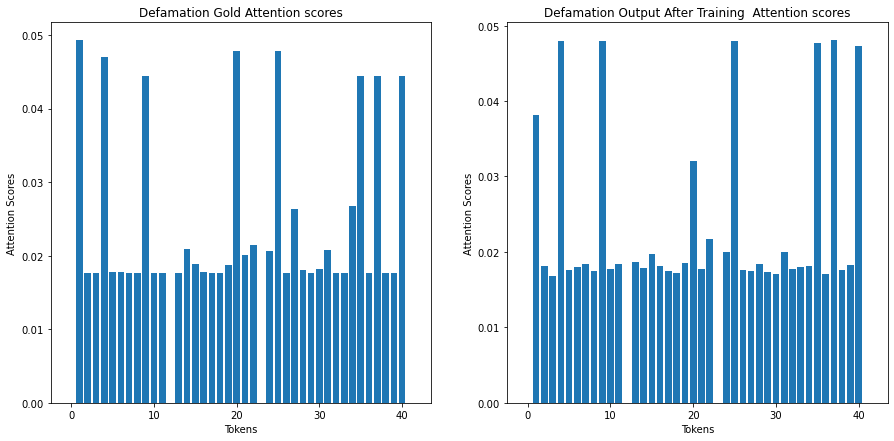

In [129]:
dim_ind  = 0
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

counter = 0
x       = np.arange(0, len(attentions[dim_ind][0]))
attn    = [attentions[dim_ind][0], attentions[dim_ind][1]]
word    = ["Gold", "Output After Training ", "Gold"]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for col in ax:
    scores = attn[counter]
    col.bar(x, scores)
    col.set_xlabel("Tokens")
    col.set_ylabel("Attention Scores")
    title = hostile[dim_ind] + word[counter] + " Attention scores"
    col.set_title(title)
    counter += 1
plt.show()

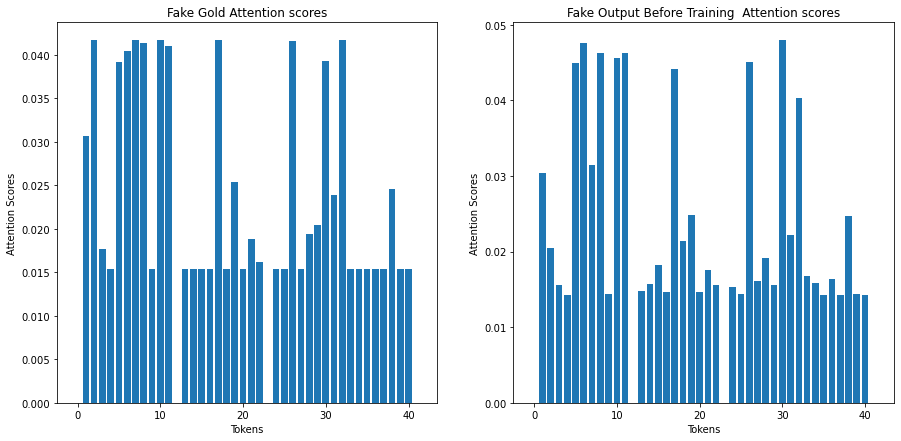

In [130]:
dim_ind  = 1
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

counter = 0
x       = np.arange(0, len(attentions[dim_ind][0]))
attn    = [attentions[dim_ind][0], attentions[dim_ind][1]]
word    = ["Gold", "Output Before Training ", "Gold", "Output After Training "]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for col in ax:
    scores = attn[counter]
    col.bar(x, scores)
    col.set_xlabel("Tokens")
    col.set_ylabel("Attention Scores")
    title = hostile[dim_ind] + word[counter] + " Attention scores"
    col.set_title(title)
    counter += 1
plt.show()

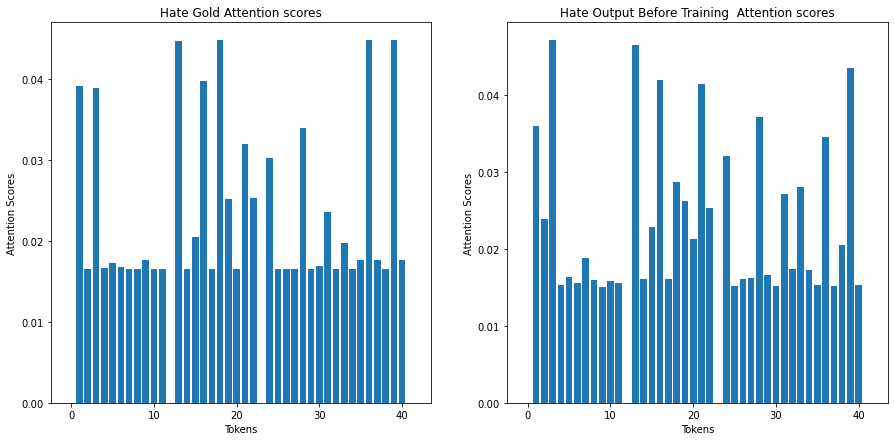

In [131]:
dim_ind  = 2
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

counter = 0
x       = np.arange(0, len(attentions[dim_ind][0]))
attn    = [attentions[dim_ind][0], attentions[dim_ind][1]]
word    = ["Gold", "Output Before Training ", "Gold", "Output After Training "]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for col in ax:
    scores = attn[counter]
    col.bar(x, scores)
    col.set_xlabel("Tokens")
    col.set_ylabel("Attention Scores")
    title = hostile[dim_ind] + word[counter] + " Attention scores"
    col.set_title(title)
    counter += 1
plt.show()

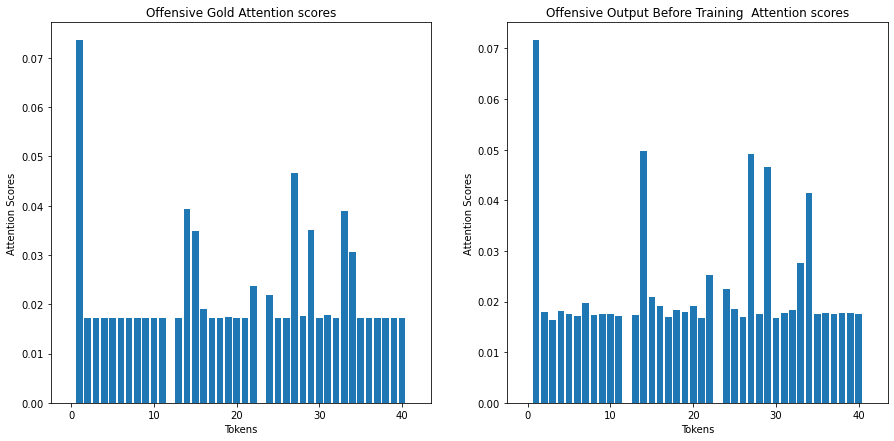

In [132]:
dim_ind  = 3
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

counter = 0
x       = np.arange(0, len(attentions[dim_ind][0]))
attn    = [attentions[dim_ind][0], attentions[dim_ind][1]]
word    = ["Gold", "Output Before Training ", "Gold", "Output After Training "]
hostile = ["Defamation ", "Fake ", "Hate ", "Offensive "]

for col in ax:
    scores = attn[counter]
    col.bar(x, scores)
    col.set_xlabel("Tokens")
    col.set_ylabel("Attention Scores")
    title = hostile[dim_ind] + word[counter] + " Attention scores"
    col.set_title(title)
    counter += 1
plt.show()

<h4> Generating Latex Attention Output

In [133]:
def get_label(label):
    label_vector = ""

    if(label[0]==1.0):
        label_vector += "defamation,"

    if(label[1]==1.0):
        label_vector += "fake,"

    if(label[2]==1.0):
        label_vector += "hate,"

    if(label[3]==1.0):
        label_vector += "offensive,"

    if(label_vector ==""):
        label_vector = "non-hostile "

    label_vector = label_vector[:-1]
    return label_vector

In [134]:
### Reference from: https://github.com/jiesutd/Text-Attention-Heatmap-Visualization/blob/master/text_attention.py

## convert the text/attention list to latex code, which will further generates the text heatmap based on attention weights.
import numpy as np

latex_special_token = ["!@#$%^&*()"]

def generate(text_list, attention_list, latex_file, flag, dim_ind, model_name, color='red', rescale_value = False):
    assert(len(text_list) == len(attention_list))
    if rescale_value:
        attention_list = rescale(attention_list)
    word_num = len(text_list)
    text_list = clean_word(text_list)
    
    if(flag==0):
        with open(latex_file,'w') as f:
            f.write(r'''
            
\documentclass{report}
\usepackage{polyglossia}

\setdefaultlanguage{hindi}
\setotherlanguage{english}

\usepackage{fontspec}
\setmainfont{Times New Roman}
\newfontfamily\devanagarifont[Scale=MatchUppercase]{Nakula}
\newfontfamily\devtransl[Mapping=DevRom]{Times New Roman}
\setmainfont{Nakula}

\special{papersize=210mm,297mm}
\usepackage{color}
\usepackage{tcolorbox}
\usepackage{CJK}
\usepackage{adjustbox}


\tcbset{width=0.9\textwidth,boxrule=0pt,colback=red,arc=0pt,auto outer arc,left=0pt,right=0pt,boxsep=5pt}


\begin{document}''' +'\n')
            
            if(dim_ind==0):
                f.write(r'''\noindent Gold Defamation Attention Scores Heatmap\\''' + '\n')

            elif(dim_ind==1):
                f.write(r'''\noindent Gold Fake Attention Scores Heatmap\\''' + '\n')

            elif(dim_ind==2):
                f.write(r'''\noindent Gold Hate Attention Scores Heatmap\\''' + '\n')
            else:
                f.write(r'''\noindent Gold Offensive Attention Scores Heatmap\\''' + '\n')

            f.write(r'''\begin{CJK*}{UTF8}{gbsn}'''+'\n')

            string = r'''{\setlength{\fboxsep}{0pt}\colorbox{white!0}{\parbox{0.9\textwidth}{'''+"\n"
            for idx in range(word_num):
                string += "\\colorbox{%s!%s}{"%(color, attention_list[idx])+"\\strut " + text_list[idx]+"} "
            string += "\n}}}"
            f.write(string+'\n')
            f.write(r'''\end{CJK*}''')
            
    if(flag==1):
         with open(latex_file,'a') as f:
            f.write(r'''\break \\ \\''' + '\n')

            if(dim_ind==0):
                f.write(r'''\noindent ''' + model_name + ''' - Defamation Attention Scores Heatmap''' + '\n')

            elif(dim_ind==1):
                f.write(r'''\noindent ''' + model_name + ''' - Fake Attention Scores Heatmap''' + '\n')

            elif(dim_ind==2):
                f.write(r'''\noindent ''' + model_name + ''' - Hate Attention Scores Heatmap''' + '\n')
            else:
                f.write(r'''\noindent ''' + model_name + ''' - Offensive Attention Scores Heatmap''' + '\n')
            
            f.write(r'''\noindent \\ \begin{CJK*}{UTF8}{gbsn}'''+'\n')

            string = r'''{\setlength{\fboxsep}{0pt}\colorbox{white!0}{\parbox{0.9\textwidth}{'''+"\n"
            for idx in range(word_num):
                string += "\\colorbox{%s!%s}{"%(color, attention_list[idx])+"\\strut " + text_list[idx]+"} "
            string += "\n}}}"
            f.write(string+'\n')
            f.write(r'''
\end{CJK*}
\end{document}''')
            

def rescale(input_list):
    the_array = np.asarray(input_list)
    the_max = np.max(the_array)
    the_min = np.min(the_array)
    rescale = (the_array - the_min)/(the_max-the_min)*100
    return rescale.tolist()


def clean_word(word_list):
    new_word_list = []
    for word in word_list:
        for latex_sensitive in [ '\\', "%", "&", "^", "_",  "{", "}", "#"]:
            if latex_sensitive in word:
                word = word.replace(latex_sensitive, '\\'+latex_sensitive)
        new_word_list.append(word)
    return new_word_list



# colors  = ['red', 'cyan', 'lime', 'orange']
colors  = ['orange', 'lime', 'red', 'cyan']



indexes = [0,1,2,3]
words = new_text
words = words[1:-1]
word_num = len(words)
label = get_label(outputs[0])

print(label,"\n\n")
file_names = [label+" Defamation.tex",label+" Fake.tex",label+" Hate.tex",label+" Offensive.tex"]

top_five = [0,0,0,0]
for dim_ind in indexes:
    for flag in range(2):
        if(flag==0):
            if(dim_ind==0):
                print("Gold Defamation Attention Scores: \n")
            
            elif(dim_ind==1):
                print("Gold Fake Attention Scores: \n")
            
            elif(dim_ind==2):
                print("Gold Hate Attention Scores: \n")
            
            else:
                print("Gold Offensive Attention Scores: \n")
        else:
            if(dim_ind==0):
                print(model_names[model_index]+"Defamation Attention Scores: \n")
            
            elif(dim_ind==1):
                print(model_names[model_index]+"Fake Attention Scores: \n")
            
            elif(dim_ind==2):
                print(model_names[model_index]+"Hate Attention Scores: \n")
            
            else:
                print(model_names[model_index]+"Offensive Attention Scores: \n")
                        
        attention = attentions[dim_ind][flag]
        attention = attention[1:-1]
        attention = [100*i for i in attention]
        attention = np.asarray(attention)
        attention = np.where(np.argsort(np.argsort(attention)) >= attention.shape[0]-10, attention, 0)

        flag_low = 1
        for attn in attention:
            if(attn>28):
                flag_low=0
                break

        if flag_low == 1:
            print("Hello")
            for i in range(len(attention)):
                attention[i] = 5*attention[i]


        for i in range(len(attention)):
            if(attention[i]>100):
                attention[i] = 99.99

            if(attention[i]>0):
                print(words[i], attention[i])





    
        print("\n\n")
        color = colors[dim_ind]
        file_name = file_names[dim_ind]
        generate(words, attention[:len(words)], file_name, flag, dim_ind, model_name, color)

hate,offensive 


Gold Defamation Attention Scores: 

Hello
@TRHLofficial 24.630689062178135
लोकतंत्र 23.52452091872692
! 22.19340205192566
हार 23.89422617852688
मैं 23.900533095002174
कुतिया 13.188795186579227
हूं 13.395758345723152
! 22.19340205192566
! 22.19340205192566
! 22.19340205192566



SLATE with KL Divergence LossDefamation Attention Scores: 

Hello
@TRHLofficial 19.05781906098127
लोकतंत्र 23.99064600467682
! 23.999296128749847
हार 16.011469066143036
है 10.834931395947933
मैं 23.96179363131523
की 10.005044750869274
! 23.836033418774605
! 24.01893585920334
! 23.62031489610672



Gold Fake Attention Scores: 

Hello
ट्रम्प 20.815277472138405
लिए 20.183831453323364
खतरा 20.81458270549774
हैं 20.64386196434498
इसके 20.815325900912285
अलावा 20.51887847483158
एक 20.81366628408432
इस 20.7534022629261
करने 19.65232938528061
योजना 20.815322175621986



SLATE with KL Divergence LossFake Attention Scores: 

Hello
के 22.485731169581413
लिए 23.817837238311768
खतरा 15.740055590867996
हैं 2

In [93]:
org_text = "संजय सिंह अर्बन नक्सलवादी के पैदाइश है साला राज्य सभा में येसा किया तो समझो ये गांवों और कस्बों में क्या करेगा ये साला जाहिल गंवार है #संजय_सिंह_गुंडा_है  #संजय_सिंह_को_गिरफ्तार_करो"

In [98]:
hashtag_text = org_text

hashtag_text = ' '.join([seg_tw.segment(word[1:]) if word[0] == '#' else "" for word in hashtag_text.split()])

hashtag_text = hashtag_text.split()

print(hashtag_text)

['संजय', '_सिंह', '_गुंडा', '_है', 'संजय', '_सिंह', '_को', '_गिरफ्तार', '_करो']


In [99]:
org_text = "#भोंकोभोंकनाआपकाकामहै"

In [100]:
hashtag_text = org_text

hashtag_text = ' '.join([seg_tw.segment(word[1:]) if word[0] == '#' else "" for word in hashtag_text.split()])

hashtag_text = hashtag_text.split()

print(hashtag_text)

['भोंकोभोंकनाआपकाकामहै']
